In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/book-recommendation/Ratings.csv
/kaggle/input/book-recommendation/Users.csv
/kaggle/input/book-recommendation/Books.csv
/kaggle/input/book-recommendation/recsys_taxonomy2.png


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
books = pd.read_csv("/kaggle/input/book-recommendation/Books.csv", sep=',', encoding='latin-1', on_bad_lines='skip', low_memory=False)

ratings = pd.read_csv("/kaggle/input/book-recommendation/Ratings.csv", sep=',', encoding='latin-1', on_bad_lines='skip', low_memory=False)

# We will don't use this dataset
users = pd.read_csv("/kaggle/input/book-recommendation/Users.csv", sep=',', encoding='latin-1', on_bad_lines='skip', low_memory=False)

In [4]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
#Make lower case Book-Title
books["Book-Title"] = books["Book-Title"].apply(func=lambda x: x.lower())

In [6]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,classical mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,clara callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,decision in normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,flu: the story of the great influenza pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,the mummies of urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [7]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [8]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [9]:
print(books.columns)
print("="*100)
print(ratings.columns)
print("="*100)
print(users.columns)

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')
Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')
Index(['User-ID', 'Location', 'Age'], dtype='object')


In [10]:
print(books.shape)
print(ratings.shape)
print(users.shape)

(271360, 8)
(1149780, 3)
(278858, 3)


In [11]:
#Check duplicate values
books.duplicated().sum()

0

In [12]:
ratings.duplicated().sum()

0

In [13]:
users.duplicated().sum()

0

In [14]:
#Check the duplicate value in particular columns
# For books dataset

print("For ISBN column: ", books['ISBN'].duplicated().sum())

print("For Book-Title column: ", books['Book-Title'].duplicated().sum())

For ISBN column:  0
For Book-Title column:  32396


In [15]:
# For Ratings Dataset

print("For ISBN column: ", ratings['ISBN'].duplicated().sum())

print("For User-Id column: ", ratings['User-ID'].duplicated().sum())

For ISBN column:  809224
For User-Id column:  1044497


In [16]:
#Check null values
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [17]:
#Check the null value very specifically
books['Book-Author'][books['Book-Author'].isnull()].index

Index([118033, 187689], dtype='int64')

In [18]:
books['Book-Author'][books['Book-Author'].isnull()].index[0]

118033

In [19]:
index_num = books['Book-Author'][books['Book-Author'].isnull()].index[0]

books.iloc[[index_num]]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
118033,0751352497,a+ quiz masters:01 earth,NaN,1999,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...


In [20]:
books.iloc[0, -1]

'http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg'

In [21]:
ratings.isna().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [22]:
#check the number of unique user
ratings['User-ID'].nunique()

105283

Visualization of Rating distribution

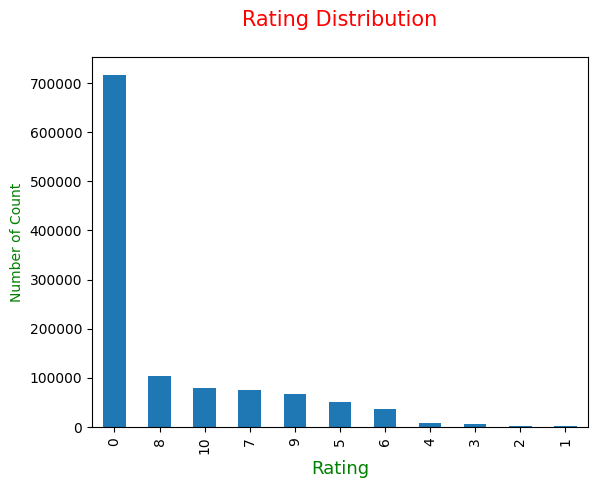

In [23]:
ratings['Book-Rating'].value_counts().plot(kind='bar')
plt.title("Rating Distribution\n", fontsize=15, color='red')
plt.xlabel("Rating", fontsize=13, color='g')
plt.ylabel("Number of Count", fontsize=10, color='g')
plt.show()

Popularity Based Recommender System

1) We will consider those Users as a Good Users which have given ratings on minimum 200 books.

2) And also we will consider those Books as a Popular Books which have got 100 time ratings

In [24]:
#Merge books dataset with ratings dataset
ratings_with_books = pd.merge(left=ratings, right=books, on="ISBN")

In [25]:
ratings_with_books.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,flesh tones: a novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,flesh tones: a novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,flesh tones: a novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,flesh tones: a novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,flesh tones: a novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [26]:
ratings_with_books.shape

(1031136, 10)

In [27]:
# Check null value

ratings_with_books.isna().sum()

User-ID                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            4
dtype: int64

Add a new column totalBookrating and make a dataframe

we will group by based on Book-Title beacuse of we already seen Book-Title contain duplicate value if we group by based on ISBN column then same book will be distribute in different group

In [28]:
# This is one way

total_number_of_rating = pd.DataFrame(data=ratings_with_books.groupby(by='Book-Title')['Book-Rating'].count())

# Change the column name
total_number_of_rating.rename(columns={'Book-Rating':'total_number_of_rating'}, inplace=True)

total_number_of_rating.reset_index(inplace=True)

total_number_of_rating.sort_values(by='total_number_of_rating', ascending=False).head(10)

# total_number_of_rating.head(10)

,Book-Title,total_number_of_rating
232037,wild animus,2502
194590,the lovely bones: a novel,1295
181406,the da vinci code,898
5627,a painted house,838
197572,the nanny diaries: a novel,828
27696,bridget jones's diary,815
205023,the secret life of bees,774
52316,divine secrets of the ya-ya sisterhood: a novel,740
202892,the red tent (bestselling backlist),723
14267,angels &amp; demons,670


In [29]:
total_number_of_rating.shape

(237912, 2)

In [30]:
# This is another way to do it

total_number_of_rating2 = ratings_with_books.groupby(by='Book-Title').count()['Book-Rating'].reset_index()

total_number_of_rating2.rename(columns={'Book-Rating':'total_number_of_rating'}, inplace=True)

total_number_of_rating2.sort_values(by="total_number_of_rating", ascending=False).head(10)

,Book-Title,total_number_of_rating
232037,wild animus,2502
194590,the lovely bones: a novel,1295
181406,the da vinci code,898
5627,a painted house,838
197572,the nanny diaries: a novel,828
27696,bridget jones's diary,815
205023,the secret life of bees,774
52316,divine secrets of the ya-ya sisterhood: a novel,740
202892,the red tent (bestselling backlist),723
14267,angels &amp; demons,670


other way

In [31]:
total_number_of_rating2.shape

(237912, 2)

In [32]:
#Add a new column AverageBookrating and make a dataframe
average_number_of_rating = pd.DataFrame(data=ratings_with_books.groupby(by='Book-Title')['Book-Rating'].mean())

average_number_of_rating.rename(columns={'Book-Rating': 'average_number_of_rating'}, inplace=True)

average_number_of_rating.reset_index(inplace=True)

average_number_of_rating.sort_values(by="average_number_of_rating", ascending=False).head(10)


,Book-Title,average_number_of_rating
218892,transformers armada: fortress,10.0
38431,confirmed bachelors are just so fascinating (d...,10.0
23789,birdseed cookies: a fractured memoir,10.0
8640,absolutely brilliant in chrome: phobos galaxy ...,10.0
212095,the wheel of time: prophecies of the dragon,10.0
212093,the wheel of time roleplaying game : roleplayi...,10.0
146967,remembering wholeness: a personal handbook for...,10.0
38461,confusing love with obsession: when you can't ...,10.0
133498,ordeal of thomas hutchinson,10.0
38456,confronting the horror: the aftermath of violence,10.0


In [33]:
average_number_of_rating.shape

(237912, 2)

In [34]:
#Let's combine the Total number of books rating and Average number of books rating
total_and_average_book_rating = total_number_of_rating.merge(right=average_number_of_rating, on="Book-Title")

total_and_average_book_rating.reset_index(inplace=True, drop=True)

total_and_average_book_rating.head(10)


,Book-Title,total_number_of_rating,average_number_of_rating
0,a light in the storm: the civil war diary of ...,4,2.25
1,always have popsicles,1,0.00
2,apple magic (the collector's series),1,0.00
3,"ask lily (young women of faith: lily series, ...",1,8.00
4,beyond ibm: leadership marketing and finance ...,1,0.00
5,clifford visita el hospital (clifford el gran...,1,0.00
6,dark justice,1,10.00
7,deceived,2,0.00
8,earth prayers from around the world: 365 pray...,10,5.00
9,final fantasy anthology: official strategy gu...,4,5.00


In [35]:
total_and_average_book_rating.shape

(237912, 3)

combine Total number of books rating and Average number of books rating

In [36]:
total_and_average_book_rating.sort_values(by="total_number_of_rating", ascending=False).head(10)

,Book-Title,total_number_of_rating,average_number_of_rating
232037,wild animus,2502,1.019584
194590,the lovely bones: a novel,1295,4.468726
181406,the da vinci code,898,4.642539
5627,a painted house,838,3.231504
197572,the nanny diaries: a novel,828,3.530193
27696,bridget jones's diary,815,3.527607
205023,the secret life of bees,774,4.447028
52316,divine secrets of the ya-ya sisterhood: a novel,740,3.437838
202892,the red tent (bestselling backlist),723,4.334716
14267,angels &amp; demons,670,3.708955


In [37]:
total_and_average_book_rating.shape

(237912, 3)

In [38]:
total_and_average_book_rating.columns

Index(['Book-Title', 'total_number_of_rating', 'average_number_of_rating'], dtype='object')

Creating new dataframe from total_and_average_book_rating

In [39]:
popular_df = total_and_average_book_rating[total_and_average_book_rating['total_number_of_rating'] >= 250].sort_values(by="average_number_of_rating", ascending=False)

popular_df.head()


,Book-Title,total_number_of_rating,average_number_of_rating
79293,harry potter and the prisoner of azkaban (book 3),428,5.852804
79281,harry potter and the goblet of fire (book 4),387,5.824289
79300,harry potter and the sorcerer's stone (book 1),278,5.737410
79285,harry potter and the order of the phoenix (boo...,347,5.501441
79273,harry potter and the chamber of secrets (book 2),556,5.183453


In [40]:
popular_df.shape

(189, 3)

In [41]:
popular_df.head()

,Book-Title,total_number_of_rating,average_number_of_rating
79293,harry potter and the prisoner of azkaban (book 3),428,5.852804
79281,harry potter and the goblet of fire (book 4),387,5.824289
79300,harry potter and the sorcerer's stone (book 1),278,5.737410
79285,harry potter and the order of the phoenix (boo...,347,5.501441
79273,harry potter and the chamber of secrets (book 2),556,5.183453


In [42]:
popular_df.shape

(189, 3)

In [43]:
#users given ratings on minimum 200 books
userId_count = ratings_with_books['User-ID'].value_counts()

userId_count.head(50)

User-ID
11676     11144
198711     6456
153662     5814
98391      5779
35859      5646
212898     4289
278418     3996
76352      3329
110973     2971
235105     2943
16795      2920
230522     2857
234623     2594
204864     2461
36836      2458
245963     2395
185233     2382
55492      2361
52584      2340
232131     2329
227447     2312
102967     2285
129358     2275
98741      2235
171118     2219
60244      2204
190925     2088
135149     2061
231210     1986
189835     1966
69697      1901
78783      1862
189334     1817
73394      1776
242824     1735
269566     1718
23768      1690
172742     1685
175003     1646
213350     1629
226545     1612
238781     1599
36606      1565
182085     1559
177458     1540
11601      1538
148744     1535
123981     1525
26544      1501
257204     1483
Name: count, dtype: int64

In [44]:
userId_count.tail(50)

User-ID
129043    1
140387    1
172753    1
225532    1
14641     1
21391     1
89144     1
52465     1
266368    1
30807     1
244184    1
74749     1
107212    1
250667    1
52363     1
100196    1
120870    1
146360    1
195056    1
205143    1
208400    1
247122    1
251793    1
209707    1
75310     1
74685     1
3940      1
58913     1
3950      1
3951      1
3952      1
85515     1
197804    1
213635    1
23370     1
59585     1
3960      1
40061     1
170999    1
26237     1
136099    1
176341    1
20685     1
145268    1
42332     1
4002      1
78202     1
4016      1
55986     1
276660    1
Name: count, dtype: int64

In [45]:
# Demo test
userId_count[userId_count >= 200]

User-ID
11676     11144
198711     6456
153662     5814
98391      5779
35859      5646
          ...  
257700      200
268622      200
35433       200
128208      200
141902      200
Name: count, Length: 816, dtype: int64

In [46]:
userId_count[userId_count >= 200].index

Index([ 11676, 198711, 153662,  98391,  35859, 212898, 278418,  76352, 110973,
       235105,
       ...
       269890, 246311, 164323, 178199, 201783, 257700, 268622,  35433, 128208,
       141902],
      dtype='int64', name='User-ID', length=816)

In [47]:
ratings_with_books['User-ID'].isin(values=userId_count[userId_count >= 200].index)

0          False
1          False
2           True
3          False
4          False
           ...  
1031131    False
1031132    False
1031133    False
1031134    False
1031135    False
Name: User-ID, Length: 1031136, dtype: bool

In [48]:
len(ratings_with_books['User-ID'].isin(values=userId_count[userId_count >= 200].index))

1031136

In [49]:
type(ratings_with_books['User-ID'].isin(values=userId_count[userId_count >= 200].index))

pandas.core.series.Series

In [50]:
filtered_rating_books = ratings_with_books[ratings_with_books['User-ID'].isin(values=userId_count[userId_count >= 200].index)]

filtered_rating_books consist of users which have given ratings on minimum 200 books.

In [51]:
filtered_rating_books

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
2,6543,034545104X,0,flesh tones: a novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
5,23768,034545104X,0,flesh tones: a novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
7,28523,034545104X,0,flesh tones: a novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
15,77940,034545104X,0,flesh tones: a novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
16,81977,034545104X,0,flesh tones: a novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
...,...,...,...,...,...,...,...,...,...,...
1030883,275970,1880837927,0,the theology of the hammer,Millard Fuller,1994,Smyth &amp; Helwys Publishing,http://images.amazon.com/images/P/1880837927.0...,http://images.amazon.com/images/P/1880837927.0...,http://images.amazon.com/images/P/1880837927.0...
1030884,275970,188717897X,0,the ordeal of integration: progress and resent...,Orlando Patterson,1998,Civitas Book Publisher,http://images.amazon.com/images/P/188717897X.0...,http://images.amazon.com/images/P/188717897X.0...,http://images.amazon.com/images/P/188717897X.0...
1030885,275970,1888889047,0,pushcart's complete rotten reviews &amp; rejec...,Bill Henderson,1998,Pushcart Press,http://images.amazon.com/images/P/1888889047.0...,http://images.amazon.com/images/P/1888889047.0...,http://images.amazon.com/images/P/1888889047.0...
1030886,275970,1931868123,0,there's a porcupine in my outhouse: misadventu...,Mike Tougias,2002,Capital Books (VA),http://images.amazon.com/images/P/1931868123.0...,http://images.amazon.com/images/P/1931868123.0...,http://images.amazon.com/images/P/1931868123.0...


In [52]:
min(filtered_rating_books['User-ID'].value_counts())

200

In [53]:
filtered_rating_books.shape

(475007, 10)

consider those books as a popular books which have got 50 time ratings

In [54]:
filtered_rating_books.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
2,6543,034545104X,0,flesh tones: a novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
5,23768,034545104X,0,flesh tones: a novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
7,28523,034545104X,0,flesh tones: a novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
15,77940,034545104X,0,flesh tones: a novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
16,81977,034545104X,0,flesh tones: a novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [55]:
filtered_rating_books.shape

(475007, 10)

In [56]:
y = filtered_rating_books.groupby(by="Book-Title")['Book-Rating'].count() >= 50

y

Book-Title
 a light in the storm: the civil war diary of amelia martin, fenwick island, delaware, 1861 (dear america)    False
 always have popsicles                                                                                        False
 apple magic (the collector's series)                                                                         False
 beyond ibm: leadership marketing and finance for the 1990s                                                   False
 clifford visita el hospital (clifford el gran perro colorado)                                                False
                                                                                                              ...  
ã?ã?ber das fernsehen.                                                                                      False
ã?ã?ber die pflicht zum ungehorsam gegen den staat.                                                         False
ã?ã?lpiraten.                                              

In [57]:
len(y)

154367

In [58]:
type(y)

pandas.core.series.Series

In [59]:
famous_books = y[y].index

famous_books

Index(['1984', '1st to die: a novel', '2nd chance', '4 blondes',
       '\o\" is for outlaw"', 'a bend in the road', 'a case of need',
       'a child called \it\": one child's courage to survive"',
       'a civil action', 'a cry in the night',
       ...
       'winter solstice', 'wish you well', 'without remorse',
       'wizard and glass (the dark tower, book 4)', 'wld accordng garp',
       'wuthering heights', 'year of wonders', 'you belong to me',
       'zen and the art of motorcycle maintenance: an inquiry into values',
       'zoya'],
      dtype='object', name='Book-Title', length=719)

In [60]:
len(famous_books)

719

from filtered_rating_books we will combine top rated books along with book title to give an advanced book-rating dataframe called popular_books

In [61]:
popular_books = filtered_rating_books[filtered_rating_books['Book-Title'].isin(values=famous_books)]

popular_books

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
63,278418,0446520802,0,the notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
65,3363,0446520802,0,the notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
66,7158,0446520802,10,the notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
69,11676,0446520802,10,the notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
74,23768,0446520802,6,the notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
...,...,...,...,...,...,...,...,...,...,...
1026724,266865,0531001725,10,the catcher in the rye,Jerome David Salinger,1973,Scholastic Library Pub,http://images.amazon.com/images/P/0531001725.0...,http://images.amazon.com/images/P/0531001725.0...,http://images.amazon.com/images/P/0531001725.0...
1027923,269566,0670809381,0,echoes,Maeve Binchy,1986,Penguin USA,http://images.amazon.com/images/P/0670809381.0...,http://images.amazon.com/images/P/0670809381.0...,http://images.amazon.com/images/P/0670809381.0...
1028777,271284,0440910927,0,the rainmaker,John Grisham,1995,Island,http://images.amazon.com/images/P/0440910927.0...,http://images.amazon.com/images/P/0440910927.0...,http://images.amazon.com/images/P/0440910927.0...
1029070,271705,B0001PIOX4,0,fahrenheit 451,Ray Bradbury,1993,Simon &amp; Schuster,http://images.amazon.com/images/P/B0001PIOX4.0...,http://images.amazon.com/images/P/B0001PIOX4.0...,http://images.amazon.com/images/P/B0001PIOX4.0...


In [62]:
popular_books.shape

(60177, 10)

In [63]:
popular_books.isna().sum()

User-ID                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

In [64]:
popular_books['User-ID'].nunique()

815

In [65]:
popular_books['Book-Rating'].nunique()

11

In [66]:
popular_books['Book-Title'].nunique()

719

creating a pivot table using popular_books features

In [67]:
pt = pd.pivot_table(data=popular_books, values="Book-Rating", index="Book-Title", columns="User-ID", fill_value=0)

pt

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0,0,0,0,0,0,0,0,0,...,10,0.0,0,0,0,0,0,0,0,0.0
1st to die: a novel,0.0,0,0,0,0,0,0,0,0,9,...,0,0.0,0,0,0,0,0,0,0,0.0
2nd chance,0.0,10,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0.0
4 blondes,0.0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0.0
"\o\"" is for outlaw""",0.0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,8,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wuthering heights,0.0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0.0
year of wonders,0.0,0,0,7,0,0,0,0,0,0,...,0,9.0,0,0,0,0,0,0,0,0.0
you belong to me,0.0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,10,0,0,0,0,0,0.0


In [68]:
pt[254]

Book-Title
1984                                                                 9.0
1st to die: a novel                                                  0.0
2nd chance                                                           0.0
4 blondes                                                            0.0
\o\" is for outlaw"                                                  0.0
                                                                    ... 
wuthering heights                                                    0.0
year of wonders                                                      0.0
you belong to me                                                     0.0
zen and the art of motorcycle maintenance: an inquiry into values    0.0
zoya                                                                 0.0
Name: 254, Length: 719, dtype: float64

Create Model Using Cosine_similarity

here we compute the cosine_similarity for the data in the pivot_table 'pt'

In [69]:
similarity_scores = cosine_similarity(X=pt)

In [70]:
similarity_scores.shape

(719, 719)

In [71]:
# Similarity first user with other user

similarity_scores[0]

array([1.        , 0.0999137 , 0.01189468, 0.        , 0.04205081,
       0.05229234, 0.02703559, 0.08005247, 0.133798  , 0.        ,
       0.03177829, 0.03573298, 0.0226271 , 0.06592522, 0.020304  ,
       0.09425025, 0.08089641, 0.1304464 , 0.10866788, 0.0496928 ,
       0.02453052, 0.11405415, 0.        , 0.13965274, 0.07645776,
       0.05992325, 0.08499677, 0.        , 0.09621379, 0.07404925,
       0.00732437, 0.01435345, 0.        , 0.07761015, 0.04406341,
       0.01486269, 0.09251799, 0.01776199, 0.02543351, 0.07778745,
       0.12026486, 0.11854319, 0.0554492 , 0.08139372, 0.07683348,
       0.08560054, 0.05350252, 0.0534403 , 0.26331669, 0.09527704,
       0.05861375, 0.08728505, 0.06575169, 0.        , 0.04353225,
       0.01871487, 0.        , 0.05484345, 0.00531237, 0.07674541,
       0.05085288, 0.18422052, 0.        , 0.01208759, 0.02775734,
       0.04169477, 0.12354122, 0.16140808, 0.        , 0.1301383 ,
       0.06445396, 0.        , 0.        , 0.        , 0.04405

In [72]:
list(enumerate(similarity_scores[0]))

[(0, 1.0),
 (1, 0.09991370443681998),
 (2, 0.011894676421575648),
 (3, 0.0),
 (4, 0.042050812160027144),
 (5, 0.0522923428754616),
 (6, 0.027035592129264218),
 (7, 0.08005246987594641),
 (8, 0.13379800079660079),
 (9, 0.0),
 (10, 0.03177829126649559),
 (11, 0.03573297811768626),
 (12, 0.022627095695491876),
 (13, 0.06592521898256122),
 (14, 0.02030399594727408),
 (15, 0.09425025422049897),
 (16, 0.08089640554206895),
 (17, 0.13044639995428942),
 (18, 0.10866787678155022),
 (19, 0.049692801008612855),
 (20, 0.024530524976685255),
 (21, 0.11405414701564792),
 (22, 0.0),
 (23, 0.13965274219894008),
 (24, 0.07645775981397283),
 (25, 0.05992324616320607),
 (26, 0.08499677059744355),
 (27, 0.0),
 (28, 0.09621378577288568),
 (29, 0.0740492482078533),
 (30, 0.007324366251940837),
 (31, 0.01435345067390976),
 (32, 0.0),
 (33, 0.07761014992531964),
 (34, 0.04406341116244771),
 (35, 0.01486268748271215),
 (36, 0.09251799313259884),
 (37, 0.017761989688713762),
 (38, 0.02543350839956968),
 (39, 0.

In [73]:
sorted(list(enumerate(similarity_scores[0])), key=lambda x : x[1], reverse=True)

[(0, 1.0),
 (48, 0.26331668558969296),
 (558, 0.25717553496685785),
 (83, 0.23060840046543507),
 (647, 0.22700367288326906),
 (564, 0.2204467783292418),
 (181, 0.21650925243379174),
 (513, 0.2142249863657188),
 (315, 0.20469829119944727),
 (353, 0.20143976888534182),
 (567, 0.19510223814372807),
 (533, 0.1945913301271719),
 (540, 0.1915092894769818),
 (501, 0.18790707816989385),
 (565, 0.18715039796581026),
 (325, 0.18515418624826524),
 (637, 0.1843874814079204),
 (611, 0.1843490366438097),
 (61, 0.18422051694704247),
 (635, 0.18094225216441853),
 (559, 0.1793562146567134),
 (661, 0.17633623834710418),
 (203, 0.17585166214330838),
 (554, 0.17528356134820602),
 (601, 0.1693494650818239),
 (550, 0.16571429613724833),
 (557, 0.16298683907968622),
 (67, 0.16140807538784901),
 (119, 0.16102364040924586),
 (363, 0.15917802996766617),
 (417, 0.15628767003519692),
 (603, 0.15588904638387238),
 (680, 0.15485243550124775),
 (92, 0.15443300128602558),
 (488, 0.1543518729334901),
 (272, 0.15387700

In [74]:
pt.index

Index(['1984', '1st to die: a novel', '2nd chance', '4 blondes',
       '\o\" is for outlaw"', 'a bend in the road', 'a case of need',
       'a child called \it\": one child's courage to survive"',
       'a civil action', 'a cry in the night',
       ...
       'winter solstice', 'wish you well', 'without remorse',
       'wizard and glass (the dark tower, book 4)', 'wld accordng garp',
       'wuthering heights', 'year of wonders', 'you belong to me',
       'zen and the art of motorcycle maintenance: an inquiry into values',
       'zoya'],
      dtype='object', name='Book-Title', length=719)

In [75]:
np.where(pt.index == "1984")

(array([0]),)

In [76]:
np.where(pt.index == "1984")[0][0]

0

In [77]:
# Let's create a recommender function

def books_recommend(bookName: str):
    try:
        bookName = bookName.lower()
        book_index = np.where(pt.index == bookName)[0][0]
        similar_books = sorted(list(enumerate(similarity_scores[book_index])), key=lambda x : x[1], reverse=True)[1:21]
    except:
        print("Error occured")
    else:
        print(similar_books)
        print("-------------------------------------------------------------------------------")
        for i in similar_books:
            print(pt.index[i[0]].capitalize())

In [78]:
# books_recommend("Harry Potter and the Chamber of Secrets (Book 2)")
books_recommend("A time to kill")

[(595, 0.3942606412794923), (518, 0.3586771918283425), (541, 0.3312305807516229), (515, 0.29053697714891374), (608, 0.2768191834779188), (641, 0.24616152168779534), (629, 0.24162349972377106), (136, 0.24035978726221138), (594, 0.23462638917608647), (432, 0.22496841011861493), (236, 0.21630787901367213), (39, 0.20691863355815998), (332, 0.20391561957222581), (173, 0.2026935508284005), (559, 0.20248501730247195), (619, 0.20054536047352378), (523, 0.19815319108525034), (2, 0.1973490309636965), (365, 0.19550827829253614), (9, 0.1952879926441593)]
-------------------------------------------------------------------------------
The pelican brief
The client
The firm
The chamber
The rainmaker
The testament
The street lawyer
Dark angel
The partner
Secrets
Harry potter and the sorcerer's stone (harry potter (paperback))
Along came a spider (alex cross novels)
Midnight bayou
Envy
The hitchhiker's guide to the galaxy
The runaway jury
The cradle will fall
2nd chance
No greater love
A cry in the nigh

Demo test step by step. how function is work

In [79]:
books[books["Book-Title"] == pt.index[1]]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1863,0446610038,1st to die: a novel,James Patterson,2002,Warner Vision,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...
4131,0316666009,1st to die: a novel,James Patterson,2001,Little Brown and Company,http://images.amazon.com/images/P/0316666009.0...,http://images.amazon.com/images/P/0316666009.0...,http://images.amazon.com/images/P/0316666009.0...


In [80]:
books[books["Book-Title"] == pt.index[1]].drop_duplicates("Book-Title")

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1863,0446610038,1st to die: a novel,James Patterson,2002,Warner Vision,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...


In [81]:
books[books["Book-Title"] == pt.index[1]].drop_duplicates("Book-Title")['Book-Title']

1863    1st to die: a novel
Name: Book-Title, dtype: object

In [82]:
type(books[books["Book-Title"] == pt.index[1]].drop_duplicates("Book-Title")['Book-Title'])

pandas.core.series.Series

In [83]:
books[books["Book-Title"] == pt.index[1]].drop_duplicates("Book-Title")['Book-Title'].values

array(['1st to die: a novel'], dtype=object)

In [84]:
list(books[books["Book-Title"] == pt.index[1]].drop_duplicates("Book-Title")['Book-Title'].values)

['1st to die: a novel']

In [85]:
def books_recommend2(bookName: str):
    bookName = bookName.lower()
    book_index = np.where(pt.index == bookName)[0][0]
    similar_books = sorted(list(enumerate(similarity_scores[book_index])), key=lambda x : x[1], reverse=True)[1:11]
    print(similar_books)
    print("="*100)
    books_info = []
    for i in similar_books:
        book_items = []
        temp_df = books[books["Book-Title"] == pt.index[i[0]]]
        book_items.extend(list(temp_df.drop_duplicates("Book-Title")["Book-Title"].values))
        book_items.extend(list(temp_df.drop_duplicates("Book-Title")["Book-Author"].values))
        book_items.extend(list(temp_df.drop_duplicates("Book-Title")["Image-URL-M"].values))
        
        books_info.append(book_items)
    
    return books_info

In [86]:
books_recommend2("The pelican brief")

[(518, 0.43923489375243807), (541, 0.4038646301611324), (24, 0.3942606412794923), (594, 0.36836066300042775), (608, 0.3494266928366363), (515, 0.30555654317891123), (629, 0.29875087841942993), (291, 0.2791615923264137), (504, 0.27670491186191204), (641, 0.27588546323959895)]


[['the client',
  'John Grisham',
  'http://images.amazon.com/images/P/038542471X.01.MZZZZZZZ.jpg'],
 ['the firm',
  'John Grisham',
  'http://images.amazon.com/images/P/0385416342.01.MZZZZZZZ.jpg'],
 ['a time to kill',
  'JOHN GRISHAM',
  'http://images.amazon.com/images/P/0440211727.01.MZZZZZZZ.jpg'],
 ['the partner',
  'John Grisham',
  'http://images.amazon.com/images/P/0385472951.01.MZZZZZZZ.jpg'],
 ['the rainmaker',
  'JOHN GRISHAM',
  'http://images.amazon.com/images/P/044022165X.01.MZZZZZZZ.jpg'],
 ['the chamber',
  'John Grisham',
  'http://images.amazon.com/images/P/0385424728.01.MZZZZZZZ.jpg'],
 ['the street lawyer',
  'JOHN GRISHAM',
  'http://images.amazon.com/images/P/0440225701.01.MZZZZZZZ.jpg'],
 ['kaleidoscope',
  'June Stepansky',
  'http://images.amazon.com/images/P/0884092097.01.MZZZZZZZ.jpg'],
 ['the bourne identity',
  'Robert Ludlum',
  'http://images.amazon.com/images/P/0553260111.01.MZZZZZZZ.jpg'],
 ['the testament',
  'John Grisham',
  'http://images.amazon.co

**Create Model Using NearestNeighbors**

In [87]:
pt.values

array([[ 9.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 10.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [88]:
pt.values.shape

(719, 815)

In [89]:
# csr_matrix remove the all zero or NaN value from the array and return a sparse matrix
# so that we can calculate distance easily

features_matrix = csr_matrix(pt.values)

In [90]:
features_matrix

<719x815 sparse matrix of type '<class 'numpy.float64'>'
	with 14645 stored elements in Compressed Sparse Row format>

In [91]:
features_matrix.shape

(719, 815)

In [92]:
# NearestNeighbors works as like KNN algorithm but NearestNeighbors is calculate distance like KNN and make cluster
# by the nearest neighbors

# Default parameter: NearestNeighbors(
#     *,
#     n_neighbors=5,
#     radius=1.0,
#     algorithm='auto',
#     leaf_size=30,
#     metric='minkowski',
#     p=2,
#     metric_params=None,
#     n_jobs=None,
# )

model_NN = NearestNeighbors(n_neighbors=7, algorithm="brute", metric="cosine")

In [93]:
model_NN.fit(X=features_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=7)

In [94]:
#Demo test step by step. how function is work
pt.iloc[4, :]


User-ID
254       0.0
2276      0.0
2766      0.0
2977      0.0
3363      0.0
         ... 
274308    0.0
275970    0.0
277427    0.0
277639    0.0
278418    0.0
Name: \o\" is for outlaw", Length: 815, dtype: float64

In [95]:
pt.iloc[4, :].values

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  8. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  3.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. , 10. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  2.5,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  5. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  6. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0

In [96]:
# Make one row and 815 number of columns
pt.iloc[4, :].values.reshape(1, -1)

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  8. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  3.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. , 10. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  2.5,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  5. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  6. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. , 

In [97]:
# It will return distances and indices those books are more similier

distances, indices = model_NN.kneighbors(X=pt.iloc[4, :].values.reshape(1, -1), n_neighbors=7, return_distance=True)

In [98]:
distances

array([[0.        , 0.525367  , 0.56481711, 0.58254334, 0.58807301,
        0.60525546, 0.61220086]])

In [99]:
distances.flatten()

array([0.        , 0.525367  , 0.56481711, 0.58254334, 0.58807301,
       0.60525546, 0.61220086])

In [100]:
indices

array([[  4, 281, 259,  91, 228, 404, 166]])

In [101]:
indices.flatten()

array([  4, 281, 259,  91, 228, 404, 166])

In [102]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(pt.index[4]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, pt.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for \o\" is for outlaw":

1: j is for judgment, with distance of 0.5253670025061992:
2: i is for innocent, with distance of 0.564817114135761:
3: c is for corpse (kinsey millhone mysteries (paperback)), with distance of 0.5825433390031585:
4: h is for homicide (kinsey millhone mysteries (paperback)), with distance of 0.5880730081365717:
5: q is for quarry, with distance of 0.6052554552329044:
6: e is for evidence: a kinsey millhone mystery (kinsey millhone mysteries (paperback)), with distance of 0.6122008554503326:


In [103]:
pt.index[4]

'\\o\\" is for outlaw"'

In [104]:
pt.loc["A Bend in the Road".lower(), :]

User-ID
254       0.0
2276      0.0
2766      7.0
2977      0.0
3363      0.0
         ... 
274308    0.0
275970    0.0
277427    0.0
277639    0.0
278418    0.0
Name: a bend in the road, Length: 815, dtype: float64

In [105]:
def books_recommend3(bookName: str):
    bookName = bookName.lower()
    distances, indices = model_NN.kneighbors(X=pt.loc[bookName, :].values.reshape(1, -1), n_neighbors=7, return_distance=True)
    for i in range(len(distances.flatten())):
        if i == 0:
            print('Recommendations for {0}:\n'.format(bookName.capitalize()))
        else:
            print('{0}: {1}, with distance of {2}:'.format(i, pt.index[indices.flatten()[i]], distances.flatten()[i]))

In [106]:
# books_recommend3("Harry Potter and the Chamber of Secrets (Book 2)")
books_recommend3("Animal Farm")

Recommendations for Animal farm:

1: 1984, with distance of 0.7366833144103071:
2: angus, thongs and full-frontal snogging: confessions of georgia nicolson, with distance of 0.758359530394306:
3: midnight, with distance of 0.7637429047975692:
4: second nature, with distance of 0.7810295902838492:
5: pleading guilty, with distance of 0.7858381581155238:
6: call of the wild, with distance of 0.790636444634327:


**Export the model and other files**

In [107]:
import pickle

In [108]:
# Save popular_df
pickle.dump(obj=popular_df, file=open(file="popular_df.pkl", mode="wb"))


In [109]:
# Save pt (pivote table)
pickle.dump(obj=pt, file=open(file="pt.pkl", mode="wb"))


In [110]:
# Save books dataframe
pickle.dump(obj=books, file=open(file="books.pkl", mode="wb"))


In [111]:
# Save similarity_scores (cosine-similarity model)
pickle.dump(obj=similarity_scores, file=open(file="similarity_scores.pkl", mode="wb"))


In [112]:
# Load the books dataframe back
test_df = pickle.load(open("books.pkl", 'rb'))


In [113]:
# Display the first few rows of the loaded dataframe
print(test_df.head())

         ISBN                                         Book-Title  \
0  0195153448                                classical mythology   
1  0002005018                                       clara callan   
2  0060973129                               decision in normandy   
3  0374157065  flu: the story of the great influenza pandemic...   
4  0393045218                             the mummies of urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/

In [114]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [115]:

from IPython.display import display, HTML

# Assuming you have the following objects defined: test_df

# Display the first few rows of the loaded dataframe with images
html_output = "<table><tr><th>Book Title</th><th>Book Author</th><th>Year of Publication</th><th>Publisher</th><th>Image</th></tr>"

for index, row in test_df.head().iterrows():
    book_title = row['Book-Title']
    book_author = row['Book-Author']
    year_of_publication = row['Year-Of-Publication']
    publisher = row['Publisher']
    image_url = row['Image-URL-M']  # You can choose any image URL
    
    # Add a row to the HTML table
    html_output += (
        f"<tr><td>{book_title}</td><td>{book_author}</td><td>{year_of_publication}</td><td>{publisher}</td>"
        f"<td><img src='{image_url}' height='100'></td></tr>"
    )

html_output += "</table>"

# Display the HTML table
display(HTML(html_output))

Book Title,Book Author,Year of Publication,Publisher,Image
classical mythology,Mark P. O. Morford,2002,Oxford University Press,
clara callan,Richard Bruce Wright,2001,HarperFlamingo Canada,
decision in normandy,Carlo D'Este,1991,HarperPerennial,
flu: the story of the great influenza pandemic of 1918 and the search for the virus that caused it,Gina Bari Kolata,1999,Farrar Straus Giroux,
the mummies of urumchi,E. J. W. Barber,1999,W. W. Norton & Company,
